In [33]:
import sys,os
__script_path=os.path.abspath(globals().get('__file__','.'))
__script_dir = os.path.dirname(__script_path)
root_dir = os.path.abspath(f'{__script_dir}/../../..')
print(root_dir)
for lib in [root_dir][::-1]:
    if lib in sys.path:
        sys.path.remove(lib)
    sys.path.insert(0,lib)
from config.config import *
from libs.common import *

c:\Users\Admin\Data\ads_fraud_detection


In [34]:
save_dir=f"{exps_dir}/exp3/exp_smote"
if os.path.exists(save_dir) == False:
  os.makedirs(save_dir, exist_ok=True)



test_size=0.33
seed=42

In [35]:
feature_selection=dict(np.load(f'{save_dir}/feature_model_selection.npz',allow_pickle=True))['feature_model_selection']
feature_selection = {key: value for key, value in feature_selection.item().items()}
feature_selection

{'LR': ['ANY_INJURY',
  'AUTHORITY_CONTACTED',
  'EMPLOYMENT_STATUS',
  'HOUSE_TYPE',
  'LOSS_DT',
  'MARITAL_STATUS',
  'Quantile_CLAIM_AMOUNT',
  'REPORT_DT',
  'SOCIAL_CLASS',
  'TXN_DATE_TIME'],
 'LDA': ['ANY_INJURY',
  'BoxCox_CLAIM_AMOUNT',
  'BoxCox_PREMIUM_AMOUNT',
  'CLAIM_AMOUNT',
  'Cubed_PREMIUM_AMOUNT',
  'Log_CLAIM_AMOUNT',
  'PREMIUM_AMOUNT',
  'Sqrt_CLAIM_AMOUNT',
  'YeoJohnson_CLAIM_AMOUNT',
  'YeoJohnson_PREMIUM_AMOUNT'],
 'DTC': ['ACCT_NUMBER',
  'ADDRESS_LINE1',
  'AGENT_ID',
  'CUSTOMER_NAME',
  'Cubed_PREMIUM_AMOUNT',
  'POLICY_EFF_DT',
  'POLICY_NUMBER',
  'ROUTING_NUMBER',
  'SSN',
  'TENURE'],
 'RD': ['ACCT_NUMBER',
  'ADDRESS_LINE1',
  'CUSTOMER_ID',
  'CUSTOMER_NAME',
  'Cubed_PREMIUM_AMOUNT',
  'POLICY_EFF_DT',
  'POLICY_NUMBER',
  'ROUTING_NUMBER',
  'SSN',
  'TRANSACTION_ID'],
 'LGBM': ['ACCT_NUMBER',
  'ADDRESS_LINE1',
  'AGENT_ID',
  'CUSTOMER_ID',
  'CUSTOMER_NAME',
  'POSTAL_CODE',
  'PREMIUM_AMOUNT',
  'ROUTING_NUMBER',
  'SSN',
  'TENURE'],
 'XGB': [

* kiểm tra và tạo các thư mục (nếu chưa có)
* tập test 33%

# 5. Xây dựng và đánh giá mô hình học sâu Neutual Network

In [36]:
bg_model=joblib.load(f'{save_dir}/bg_model.joblib')
rf_model=joblib.load(f'{save_dir}/rf_model.joblib')
svm_model=joblib.load(f'{save_dir}/svm_model.joblib')

In [37]:
x_train=pd.read_excel(f'{save_dir}/x_train.xlsx')
y_train=pd.read_excel(f'{save_dir}/y_train.xlsx')
x_test=pd.read_excel(f'{save_dir}/x_test.xlsx')
y_test=pd.read_excel(f'{save_dir}/y_test.xlsx')
class_weights_dict=dict(np.load(f'{save_dir}/class_weights_dict.npz',allow_pickle=True))['class_weights_dict']
class_weights_dict = {key: value for key, value in class_weights_dict.item().items()}
class_weights_dict

{0: 0.5263984915147706, 1: 9.970238095238095}

In [38]:


# Dữ liệu label đã được mã hóa
def oneHot(arr):
    labels = np.array(arr)
    encoder = OneHotEncoder(sparse=False)

    labels_reshaped = labels.reshape(-1, 1)

    encoder.fit(labels_reshaped)

    onehot_labels = encoder.transform(labels_reshaped)
    # onehot_labels=pd.DataFrame(onehot_labels)
    return onehot_labels

y_train_onehot=oneHot(y_train)
y_test_onehot=oneHot(y_test)
print(y_test_onehot.shape,y_train_onehot.shape)


(3300, 2) (12728, 2)


In [39]:
y_test_onehot.reshape(-1, 1)
print(y_test_onehot.shape)

(3300, 2)


In [40]:
x_test.shape

(3300, 47)

In [41]:
x_train.shape

(12728, 47)

In [42]:
y_train.value_counts()

CLAIM_STATUS
0               6364
1               6364
Name: count, dtype: int64

In [43]:
def f1_score(y_true, y_pred):
    """
    Macro F1 score metric.
    """
    y_pred = K.round(y_pred)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=0)
    false_positives = K.sum(K.round(K.clip(y_pred - y_true, 0, 1)), axis=0)
    false_negatives = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)), axis=0)
    precision = true_positives / (true_positives + false_positives + K.epsilon())
    recall = true_positives / (true_positives + false_negatives + K.epsilon())
    f1_scores = 2 * (precision * recall) / (precision + recall + K.epsilon())
    macro_f1_score = K.mean(f1_scores)

    return macro_f1_score

In [44]:
print(x_train.shape[1])

47


#### * Xây dựng model:

In [45]:

early_stopping = EarlyStopping(monitor='f1_score',
                                mode='max',
    min_delta=0.00005,
    patience=100,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='f1_score',
    mode='max',
    factor=0.5,
    patience=10,
    min_lr=0.000001,
    verbose=1,
)
checkpoint_callback = ModelCheckpoint(
    filepath='best_model.h5',  # Đường dẫn để lưu model
    monitor='f1_score',  # Theo dõi val_loss
    mode='max',
    save_best_only=True,  # Lưu lại chỉ model có val_loss tốt nhất
    verbose=1  # Hiển thị thông báo khi lưu model
)



#### * Xây dựng Stacked_model:

In [46]:
from sklearn.base import BaseEstimator, ClassifierMixin
import numpy as np
import tensorflow as tf
from tabnet_keras import TabNetClassifier

class TabNetWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, **kwargs):
        self.kwargs = kwargs

    def fit(self, X, y):
        self.model = TabNetClassifier(n_classes = 1, out_activation = 'sigmoid',**self.kwargs)
        self.model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy',f1_score])

        self.model.fit(X, y, epochs=10, batch_size=64, class_weight={0:0.4,1:9.5})
        return self

    def predict(self, X):
        proba = self.model.predict(X)
        return (proba > 0.5).astype(int)

    def predict_proba(self, X):
        return self.model.predict(X)

    def summary(self):
        return self.model.summary()

In [47]:
tabnet_params = {
    "decision_dim": 16,
    "attention_dim": 16,
    "n_steps": 3,
    "n_shared_glus": 2,
    "n_dependent_glus": 2,
    "relaxation_factor": 1.3,
    "epsilon": 1e-15,
    "momentum": 0.98,
    "mask_type": "softmax", # can be 'sparsemax' or 'softmax'
    "lambda_sparse": 1e-3,
    "virtual_batch_splits": 8 #number of splits for ghost batch normalization, ideally should evenly divide the batch_size
}
tabnet = TabNetWrapper(**tabnet_params)


In [48]:


# param_grid_svc = {
#     'C': [0.1, 1, 10, 100, 1000],
#     'gamma': ['scale', 'auto'],
# }



# grid_search_svm  = GridSearchCV(estimator=SVC(kernel='rbf',class_weight= 'balanced', probability=True, random_state=seed),
#                               param_grid=param_grid_svc,
#                               scoring='f1',
#                               cv=5, n_jobs=-1, verbose=2)
# grid_search_svm .fit(x_train[feature_selection['SVM']], y_train)
# svm_model = grid_search_svm .best_estimator_

# dump(svm_model, f'{save_dir}/svm_model.joblib')

# print("Best SVM Hyperparameters:")
# print(grid_search_svm .best_params_)


In [49]:
from sklearn.ensemble import StackingClassifier

# def create_keras_model():
#     # Thêm các lớp khác vào đây
#     best_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',f1_score])
#     best_model.load_weights('weights.h5')
#     return best_model

# tabnet = KerasClassifier(build_fn=create_keras_model, epochs=10)

# rf_model=RandomForestClassifier(n_estimators=100, random_state=seed)
# bg_model=GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=seed)
# svm_model=SVC(kernel='rbf',probability=True, gamma='scale' , random_state=seed)

# # Huấn luyện các mô hình cơ sở
# rf_model.fit(x_train, y_train)
# bg_model.fit(x_train, y_train)
# svm_model.fit(x_train, y_train)


# Dự đoán đầu ra của các mô hình cơ sở
rf_pred = rf_model.predict_proba(x_test[feature_selection['RD']])
svm_pred = svm_model.predict_proba(x_test[feature_selection['SVM']])
bg_pred = bg_model.predict_proba(x_test[feature_selection['BG']])



# keras_pred = tabnet.predict(x_test)
stacked_input = np.column_stack((rf_pred,svm_pred,bg_pred))


#history=model.fit(x=x_train,y=y_train,
          #validation_data=(x_test,y_test),class_weight=class_weights_dict ,
          #batch_size=64,epochs=120, callbacks=[confusion_matrix_callback])

# tabnet = KerasClassifier(build_fn=model_output, tabnet_params=tabnet_params,batch_size=64,epochs=10000,callbacks=[early_stopping,lr_scheduler])

# Clone lại để tránh thay đổi trực tiếp vào mô hình gốc
# tabnet = clone(tabnet)
# Xây dựng mô hình stacking
stacked_model = StackingClassifier(
    estimators=[('rf',rf_model), ('svm',svm_model),('bg',bg_model)],
    final_estimator=tabnet
)
print(stacked_input.shape)
print(y_test.shape)
# Tiếp tục với việc huấn luyện và đánh giá mô hình stacking
# stacked_model.fit(stacked_input, y_train)
# stacked_pred = stacked_model.predict(stacked_input)
# stacked_pred

(3300, 6)
(3300, 1)


In [50]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

# Khởi tạo StratifiedKFold với 5 phần
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

fold_accuracies = []

for train_index, test_index in skf.split(stacked_input, y_test):
    stacked_input_fold, X_test_fold =stacked_input[train_index],stacked_input[test_index]
    y_train_fold, y_test_fold =y_test.iloc[train_index], y_test.iloc[test_index]
    stacked_model.fit(stacked_input_fold, y_train_fold)    
    y_pred_fold = stacked_model.predict(X_test_fold)    
    accuracy = accuracy_score(y_test_fold, y_pred_fold)
    fold_accuracies.append(accuracy)

mean_accuracy = sum(fold_accuracies) / len(fold_accuracies)
print("Accuracy on each fold:", fold_accuracies)
print("Mean accuracy across all folds:", mean_accuracy)


Epoch 1/10
42/42 [==============================] - 4s 4ms/step - loss: 0.6690 - accuracy: 0.7527 - f1_score: 0.0655
Epoch 2/10
42/42 [==============================] - 0s 4ms/step - loss: 0.6616 - accuracy: 0.7727 - f1_score: 0.0645
Epoch 3/10
42/42 [==============================] - 0s 4ms/step - loss: 0.6321 - accuracy: 0.7561 - f1_score: 0.0754
Epoch 4/10
42/42 [==============================] - 0s 4ms/step - loss: 0.6404 - accuracy: 0.7280 - f1_score: 0.0702
Epoch 5/10
42/42 [==============================] - 0s 4ms/step - loss: 0.6361 - accuracy: 0.7333 - f1_score: 0.0741
Epoch 6/10
42/42 [==============================] - 0s 4ms/step - loss: 0.6320 - accuracy: 0.7133 - f1_score: 0.0941
Epoch 7/10
42/42 [==============================] - 0s 4ms/step - loss: 0.6457 - accuracy: 0.6758 - f1_score: 0.0617
Epoch 8/10
42/42 [==============================] - 0s 4ms/step - loss: 0.6365 - accuracy: 0.6670 - f1_score: 0.0794
Epoch 9/10
42/42 [==============================] - 0s 4ms/step 

In [51]:
# rf_pred = rf_model.predict_proba(x_test[feature_selection['RD']])
# svm_pred = svm_model.predict_proba(x_test[feature_selection['LGBM']])
# bg_pred = bg_model.predict_proba(x_test[feature_selection['XGB']])
# stacked_input = np.column_stack((rf_pred,svm_pred,bg_pred))
stacked_pred = stacked_model.predict(stacked_input)


104/104 [==============================] - 0s 1ms/step


In [52]:
# stacked_model.fit(stacked_input, y_test)
# Dự đoán và đánh giá mô hình stacked
stacked_pred = stacked_model.predict(stacked_input)
stacked_pred_labels = (stacked_pred > 0.3).astype(int)
accuracy_stacked = accuracy_score(y_test, stacked_pred_labels)
print(f'Accuracy of Stacked Model: {accuracy_stacked}')

104/104 [==============================] - 0s 1ms/step
Accuracy of Stacked Model: 0.8196969696969697


#### * Kết quả đánh giá mô hình:

In [53]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix




accuracy = accuracy_score(y_test, stacked_pred_labels)
print("Accuracy:", accuracy)

print("Classification Report:")
print(classification_report(y_test, stacked_pred_labels,labels=[1,0]))

# print("Confusion Matrix:")
# print(confusion_matrix(y_test, y_pred,labels=[1,0]))

Accuracy: 0.8196969696969697
Classification Report:
              precision    recall  f1-score   support

           1       0.12      0.43      0.19       167
           0       0.96      0.84      0.90      3133

    accuracy                           0.82      3300
   macro avg       0.54      0.63      0.55      3300
weighted avg       0.92      0.82      0.86      3300



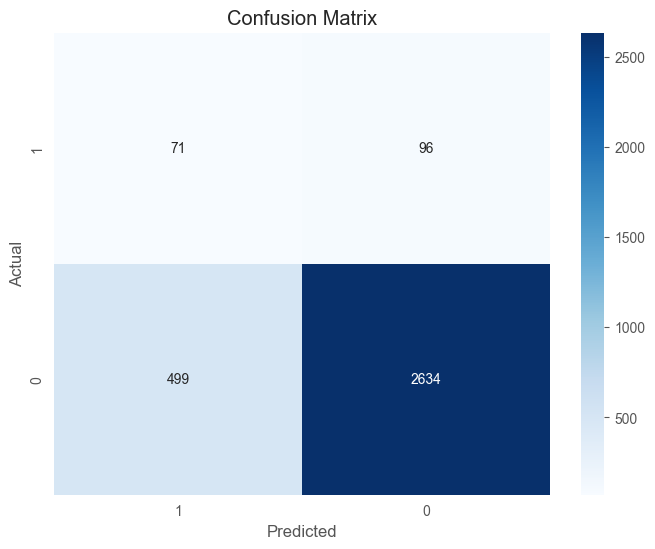

In [54]:
# Dự đoán


# Tính ma trận nhầm lẫn
cm = confusion_matrix(y_test, stacked_pred_labels,labels=[1,0])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=[1,0], yticklabels=[1,0])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

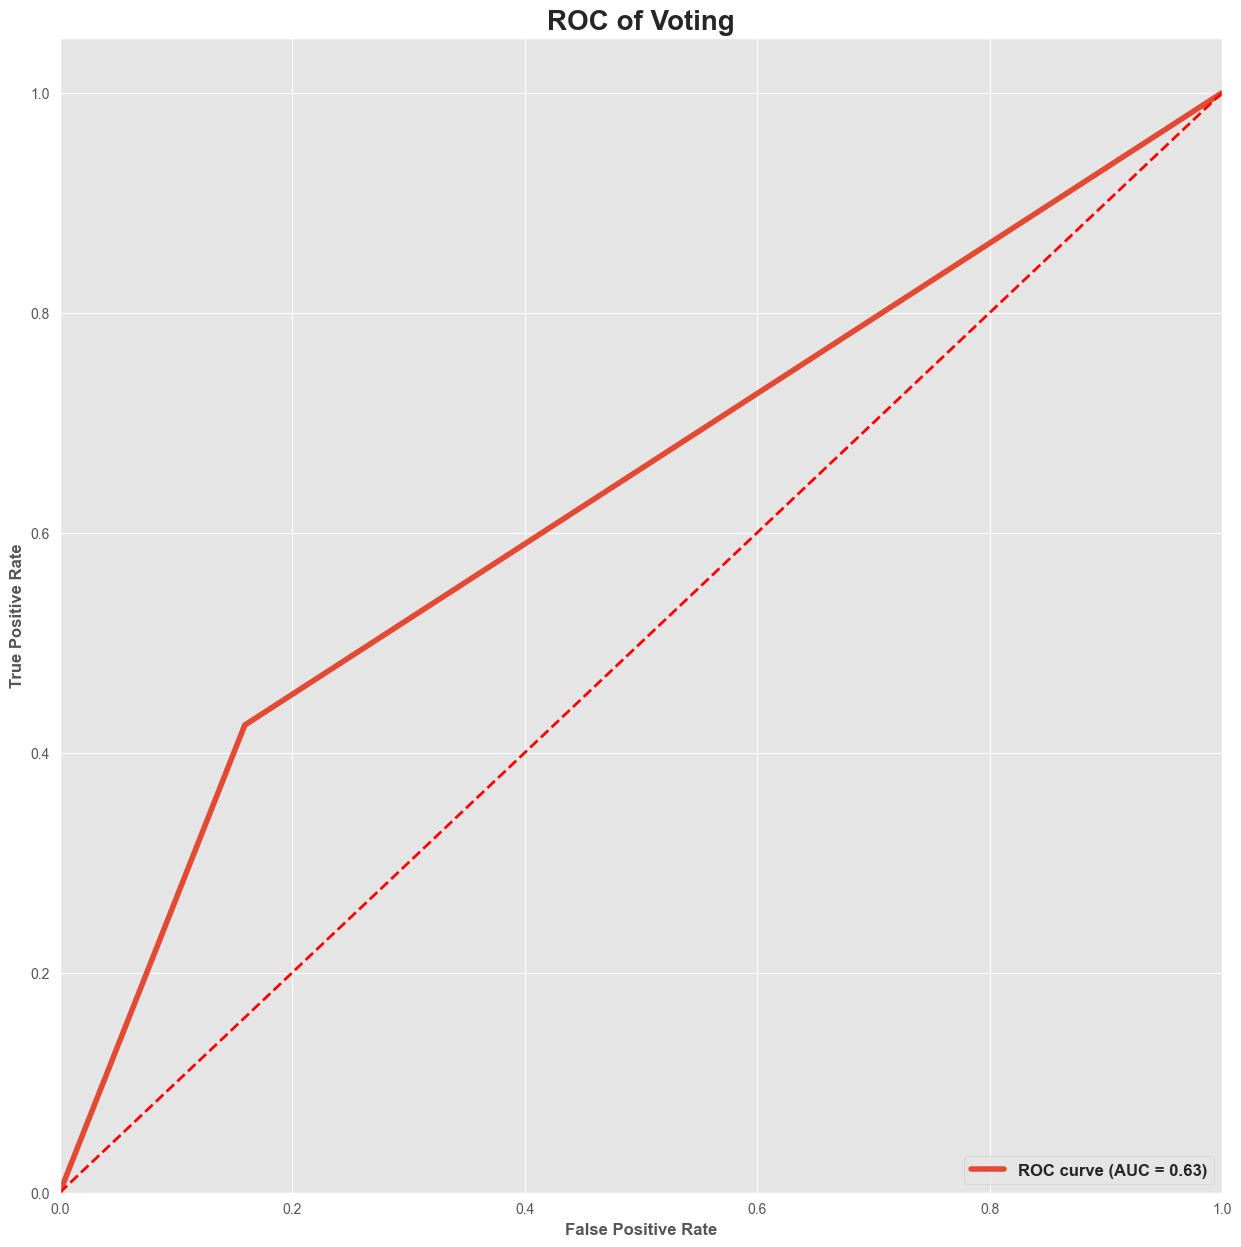

In [55]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))

fpr, tpr, _ = roc_curve(y_test, stacked_pred)

roc_auc = auc(fpr, tpr)

ax.plot(fpr, tpr, lw=4, label='ROC curve (AUC = %0.2f)' % roc_auc)
ax.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=12, weight='bold')
ax.set_ylabel('True Positive Rate', fontsize=12, weight='bold')
ax.set_title(f'ROC of Voting',fontsize=20, weight='bold')
ax.legend(loc="lower right", prop={'size': 12, 'weight': 'bold'})
plt.show()

In [56]:
def check_result(prediction):
    prediction = (prediction > 0.2).astype(int)
    if isinstance(prediction, (np.ndarray, pd.Series)):
        prediction = prediction.item()  # Hoặc sử dụng prediction[0] hoặc prediction.iloc[0]
    if prediction==1:
        return "Y"
    else:
        return "N"

In [57]:
solandung=0
hopdonggianlan=0
for indx in range(len(x_test)):
    y_predict = stacked_model.predict(stacked_input)
    stacked_pred_labels = y_predict.argmax(axis=1)

    #print(y_predict[0][0])
    Y_check = check_result(y_test.iloc[indx])
    print('True:', Y_check)
    print('Predicted:', check_result(stacked_pred_labels[indx]))
    print("----------------------------")
    if Y_check==check_result(stacked_pred_labels[indx]):
        solandung+=1
        if Y_check=='Y':
            hopdonggianlan+=1


104/104 [==============================] - 0s 1ms/step


AxisError: axis 1 is out of bounds for array of dimension 1

In [ ]:
print(f"Số lần dự đoán đúng: {solandung} chiếm khoảng {(solandung/len(x_test))*100}% tổng lần dự đoán")
print(f"Số hợp đồng gian lận trong lần kiểm tra: {hopdonggianlan} chiếm khoảng {(hopdonggianlan/len(y_test[y_test['fraud_reported']==1]))*100}% so với thực tế")


Số lần dự đoán đúng: 275 chiếm khoảng 83.33333333333334% tổng lần dự đoán
Số hợp đồng gian lận trong lần kiểm tra: 75 chiếm khoảng 85.22727272727273% so với thực tế
